# Forecasting with FB Prophet

https://facebook.github.io/prophet/

From the facebook page...

"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."



This python program will forecast out the stock price of the chosen company AMD. 
This will be the first program of two to attempt to accurately forecast stock prices. The second program will focus on neural networks. 

Stock data is time series although there is no real seasionality persay although AMD may have some seasonality in there data due to an increase in their processors during the November and December time frames. Will this mean an increase in stock price? We will see. 

In [ ]:
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io, base64, os, json, re, glob
import datetime
from datetime import timedelta
import pandas as pd
import pydata_google_auth
import pandas_datareader as web
import numpy as np

from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**There will be two ways we want to forecast. 
The first will be to take the daily data. 
The second method will be to resample the dataset to a Monthly and Yearly data set to compare with the daily.**

# Import / Scrape Data

In [ ]:
# Lets grab the data from Yahoo and store the variable as amd which is the name of the stock
# Grab the data for AMD
amd_org = web.DataReader('AMD', data_source='yahoo', start = "2013-01-01", end = '2020-07-10')

# From here we can split the methods by storing different variables
# amd will ocntinue to be our original method to forecast by day
# The second method will be stored in two variables

amd_m2_year = amd_org
amd_m2_month = amd_org

# This is necessary as we want to resample the data which summarizes the data into months as well as years
# To do this in the next section we need to take the index and pop it off to make it a column as 
# the current index is the date format and we cannot run Prophet without a data column. 

# Resample split data from above

In [ ]:
# Resample the data to month and year as well as quarter
# Gives us different forecasting options

amd_month = amd_m2_month.resample("M").mean()
amd_quarter = amd_m2_month.resample("3M").mean()
amd_year = amd_m2_year.resample("Y").mean()

Re-Index the data

This has to  be done after resampling
Average has to be run. 

(.sum() can also be used but not relevant since we dont want a summary of stock prices)

In [ ]:
# This resets the index and pushes out the Date which was our original index and now we can use it for forecasting
# If drop is = to True, this will drop the Date index since this was our original index and we will get a default index. 
# We want to set drop = False since we want a new index but still want to keep the Date column for forecasting. 
# We also want to keep inplace as True. If False, the Date column stays in the index. 

amd_org.reset_index(inplace = True, drop = False)

# The same will be done on the Month, Quarter and Year versions of the data

amd_month.reset_index(inplace = True, drop = False) 
amd_quarter.reset_index(inplace = True, drop = False)
amd_year.reset_index(inplace = True, drop = False)

In [ ]:
amd_org.tail(10)

,Date,High,Low,Open,Close,Volume,Adj Close
1884,2020-06-26,51.950001,49.450001,51.849998,50.099998,65485700,50.099998
1885,2020-06-29,50.279999,48.419998,50.150002,50.279999,49905800,50.279999
1886,2020-06-30,52.770000,50.820000,51.160000,52.610001,42275700,52.610001
1887,2020-07-01,52.869999,51.599998,52.630001,52.580002,32370900,52.580002
1888,2020-07-02,53.189999,52.049999,53.029999,52.340000,29081400,52.340000
1889,2020-07-06,53.520000,52.330002,52.900002,53.400002,36769400,53.400002
1890,2020-07-07,54.169998,52.860001,53.279999,52.930000,32153100,52.930000
1891,2020-07-08,53.470001,52.070000,53.009998,53.430000,35608300,53.430000
1892,2020-07-09,57.580002,53.310001,53.520000,57.259998,87216300,57.259998
1893,2020-07-10,58.150002,55.509998,57.540001,55.880001,59839700,55.880001


No handles with labels found to put in legend.


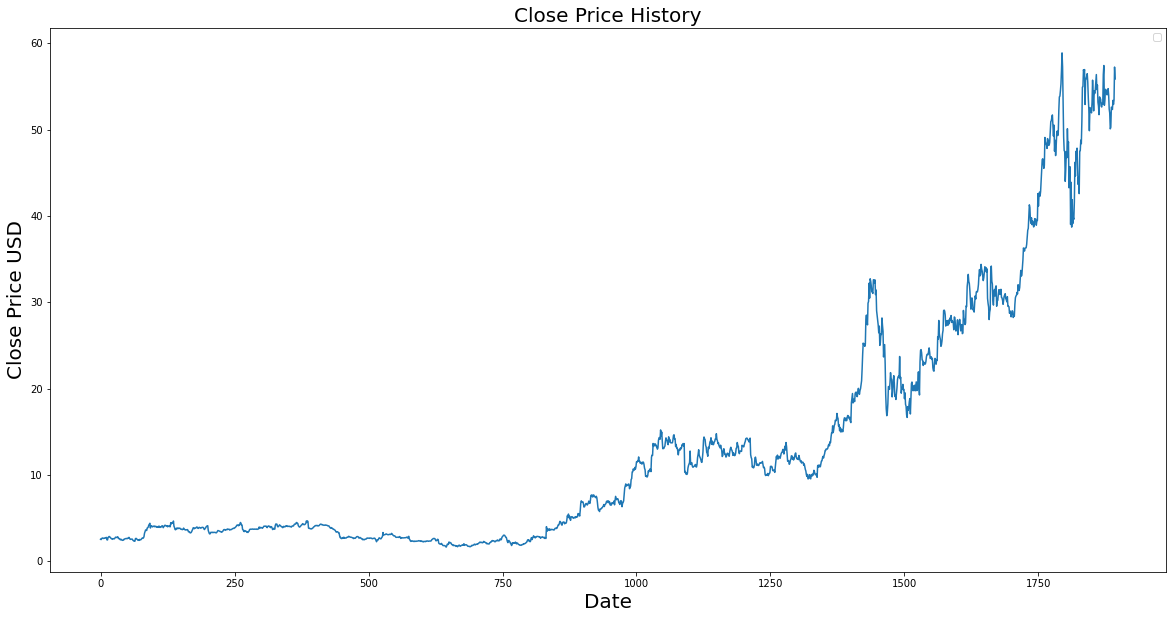

In [ ]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History", fontsize = 20)
plt.plot(amd_org['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

No handles with labels found to put in legend.


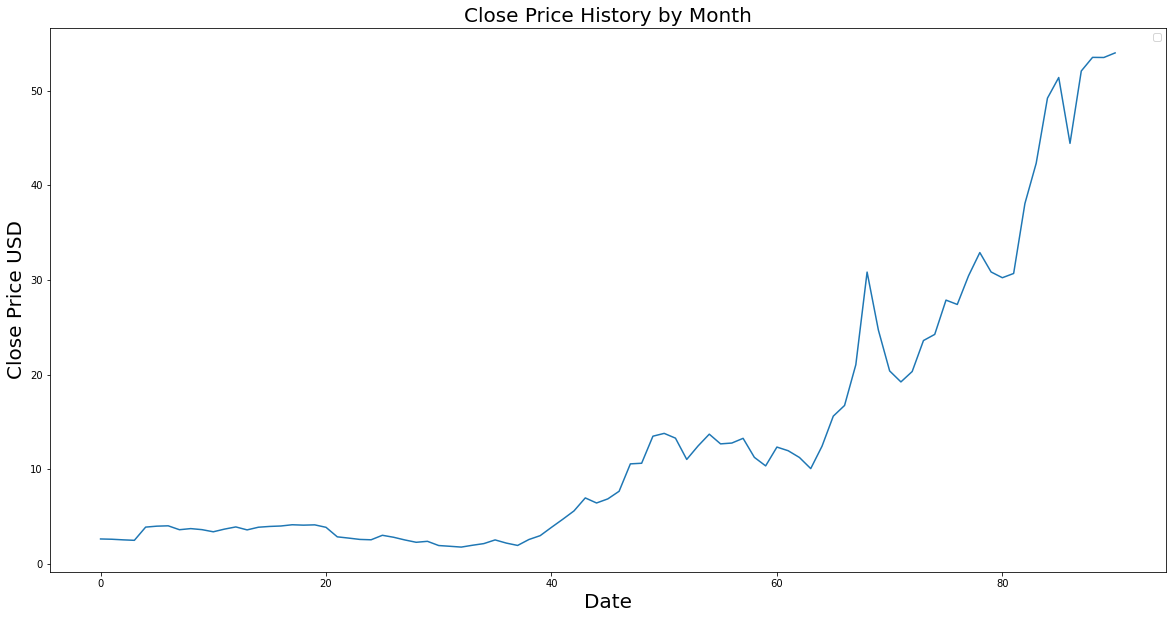

In [ ]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History by Month", fontsize = 20)
plt.plot(amd_month['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

No handles with labels found to put in legend.


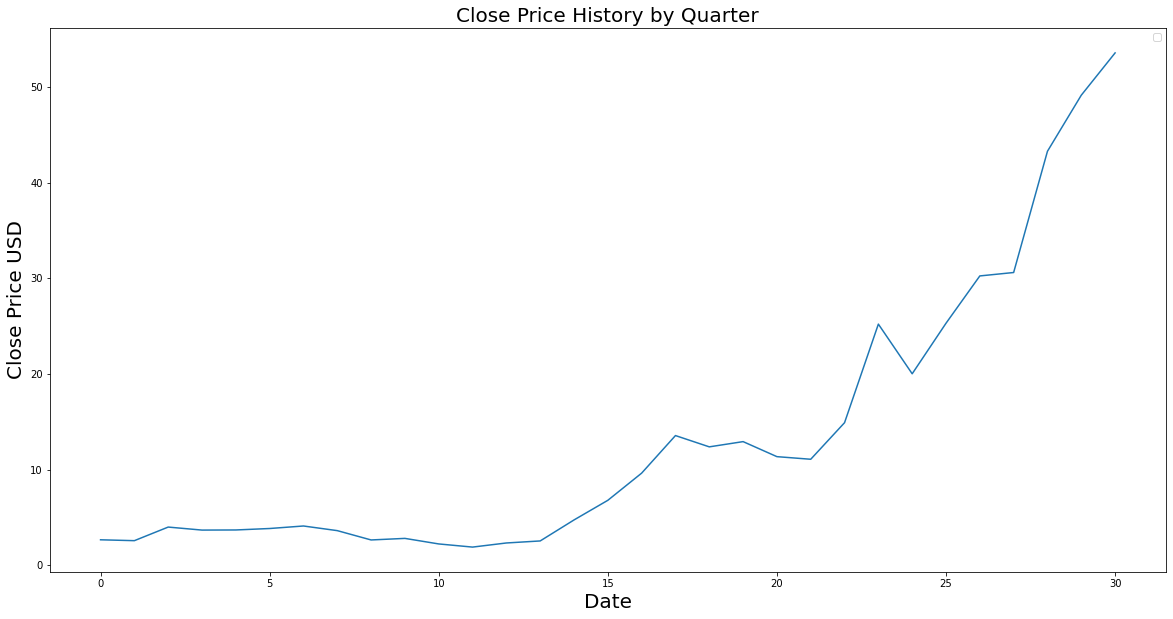

In [ ]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History by Quarter", fontsize = 20)
plt.plot(amd_quarter['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

No handles with labels found to put in legend.


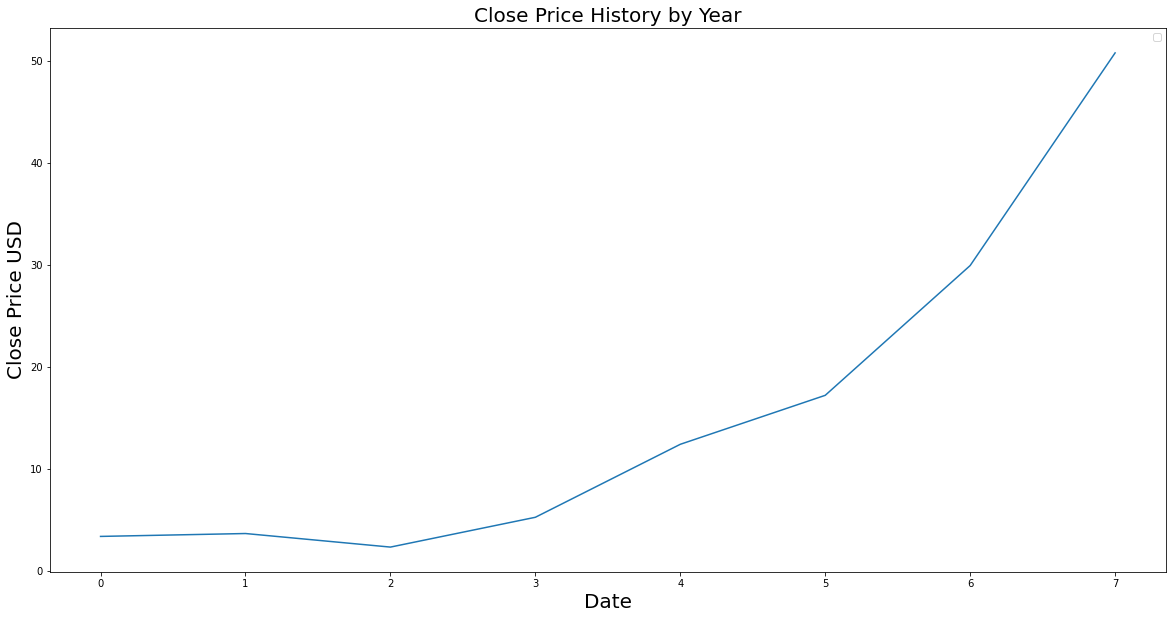

In [ ]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History by Year", fontsize = 20)
plt.plot(amd_year['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

Export the data out to excel if desired

In [ ]:
# library needed for google importing or exporting
from google.colab import files

# name your csv
amd_org.to_csv('amd_org.csv') 

# download said csv
files.download('amd_org.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Check to see what kind of data type the data column in
amd_org.Date.dtype


dtype('<M8[ns]')

No handles with labels found to put in legend.


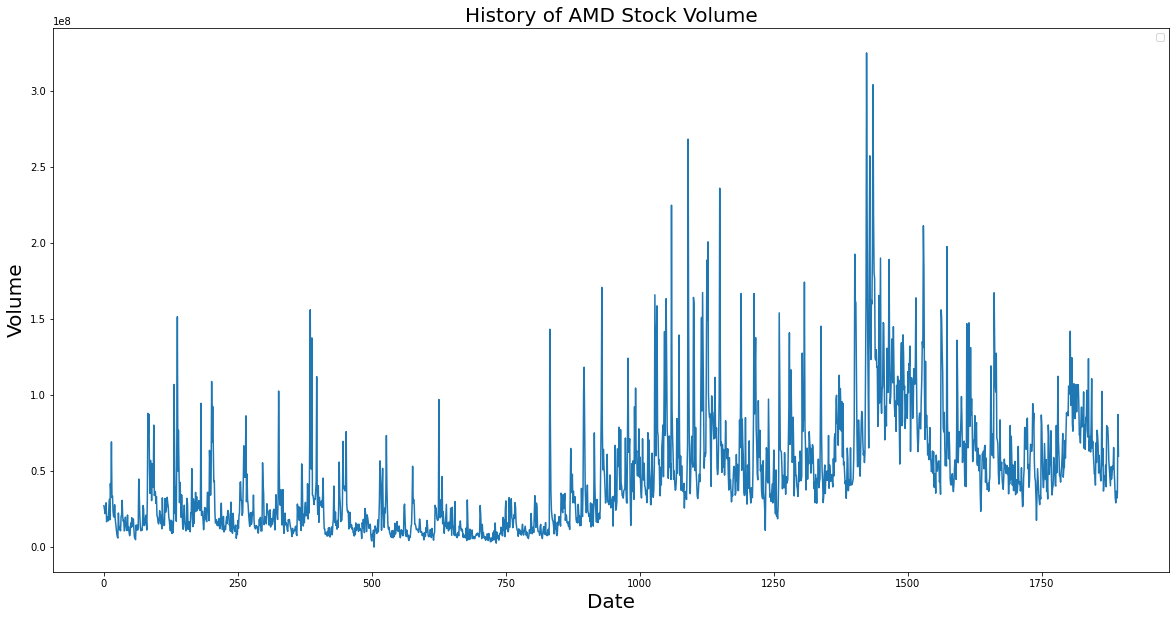

In [ ]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("History of AMD Stock Volume", fontsize = 20)
plt.plot(amd_org['Volume'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Volume', fontsize = 20)
plt.legend()
plt.show()

# Data Prepearation

Prepare data so that it can be used in the prophet model. 
One column should be ds which is the date while the y column represents the values. 

Daily Data -

In [ ]:
# Make a copy of the original data set so that we can use it for later. 
amd = amd_org

# The closing price will be what we forecast
amd_close = amd.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)

# If the data is not in the appropriate format this code will change the date
# column to date time and the second line will convert Y or the price to a number
# In this case nothing is needed to be done
# amd_close['ds'] = pd.to_datetime(amd_close['Date'])
# amd_close['y'] = amd_close['Close'].astype(float)

# Rename the columns
amd_close = amd_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_close

,ds,y
0,2013-01-02,2.530000
1,2013-01-03,2.490000
2,2013-01-04,2.590000
3,2013-01-07,2.670000
4,2013-01-08,2.670000
...,...,...
1889,2020-07-06,53.400002
1890,2020-07-07,52.930000
1891,2020-07-08,53.430000
1892,2020-07-09,57.259998


Monthly, Yearly and Quarterly Data Preprocessing

Same thing as we did above, just prepping the data although we will not be using this data for the models. 

In [ ]:
# The closing price will be what we forecast
amd_month_close = amd_month.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)
amd_quarter_close = amd_quarter.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)
amd_year_close = amd_year.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)

# If the data is not in the appropriate format this code will change the date
# column to date time and the second line will convert Y or the price to a number
# In this case nothing is needed to be done
# amd_month_close['ds'] = pd.to_datetime(amd_month_close['Date'])
# amd_month_close['y'] = amd_month_close['Close'].astype(float)

# Rename the columns
amd_month_close = amd_month_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_quarter_close = amd_quarter_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_year_close = amd_year_close.rename(columns={'Date': 'ds', 'Close': 'y'})

# Just a note, this prepocessed data is ONLY that, it was not used and will not be used in the any modeling. 

# Modeling

# 1st Model
Closing Volume Prediction for the next 2 months (60 days)

In [ ]:
# Change the standard 80% to 95%
model = Prophet(interval_width=0.95)
# Let's take out holidays for the US since the stock market wont be open during those days
model = model.add_country_holidays(country_name='US')
# Fit the model
model.fit(amd_close)
# Forecast the future dates based on the data
future_dates = model.make_future_dataframe(periods=60)
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(60)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1894,2020-07-11,55.573990,51.637767,59.325297
1895,2020-07-12,55.671787,51.877366,59.538587
1896,2020-07-13,55.518096,51.117828,59.291626
1897,2020-07-14,55.652690,51.609831,59.659270
1898,2020-07-15,55.705976,51.866936,60.162697
1899,2020-07-16,55.793721,52.084443,59.712370
1900,2020-07-17,55.849684,51.873487,59.429465
1901,2020-07-18,56.206235,52.318637,59.817218
1902,2020-07-19,56.281019,52.534436,60.195023
1903,2020-07-20,56.100451,52.417189,60.026208


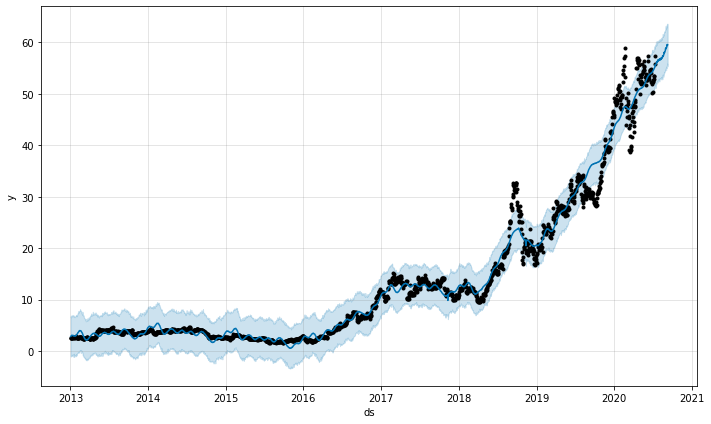

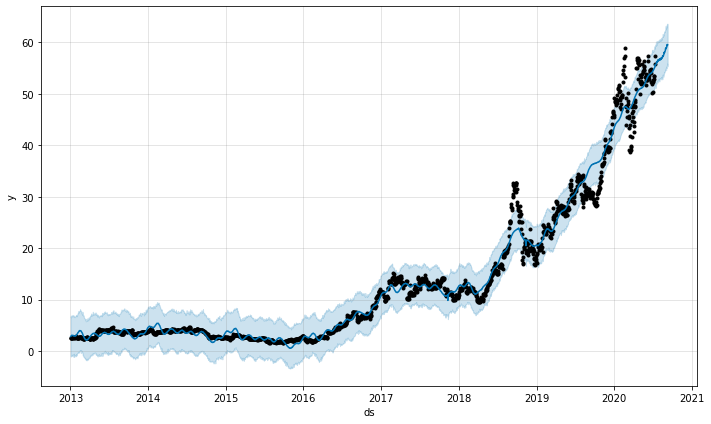

In [ ]:
# The black dots is the training data, current known stock prices in this case. 
# The forecasted values are the (blue line) and the uncertainty intervals of our 
# forecasts (the blue shaded regions).
model.plot(forecast, uncertainty = True, xlabel = 'ds', ylabel = 'y')

# Yearly, Day of Week and Monthly Findings

- In the first graph it can be seen that the forecast by mid July is nearly $60. 
- The second graph shows there is generally a spike on Friday's for the AMD stock. 
- Interesetingly in the 4th quarter, around November the stock dips to its lowest of the year but then jumps up in December. This may be caused by Black Friday and Christmas sales. (Additional data may need to be brought in to understand this jump)

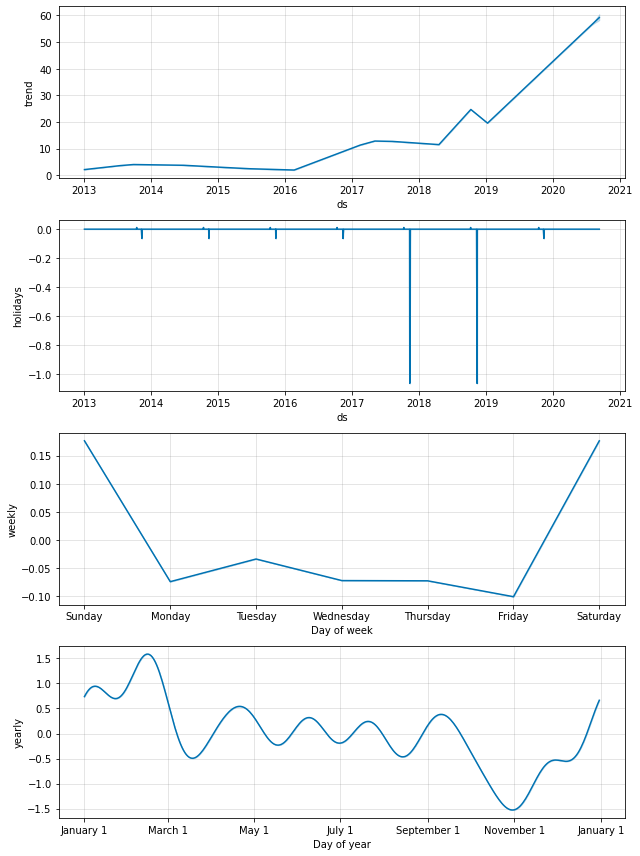

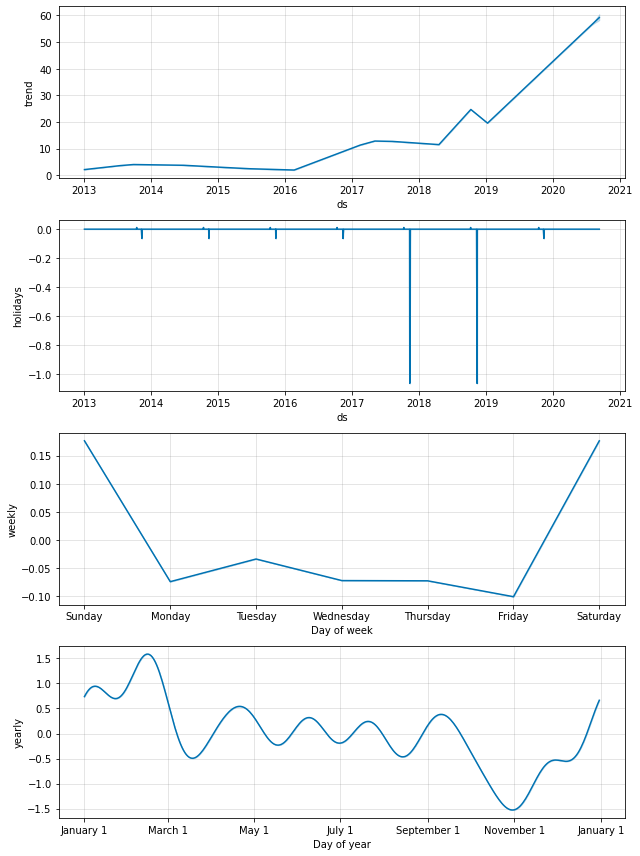

In [ ]:
# Daily, weekly and yearly patterns
model.plot_components(forecast)

# Filtered View for Comparison

Let's filter the dataframe by taking out the last 2 months (June and July) to see if prophet can forecast properly. 

This is another way of taking a look at the differences between what is ongoing and what was forecasted. 

In [ ]:
# Here we are filtering on a data set to take out all of June and July
filtered_date = amd_close[amd_close["ds"] <= "2020-05-31"]
filtered_date.tail(10)

,ds,y
1855,2020-05-15,54.200001
1856,2020-05-18,54.590000
1857,2020-05-19,55.470001
1858,2020-05-20,56.389999
1859,2020-05-21,54.650002
1860,2020-05-22,55.169998
1861,2020-05-26,53.189999
1862,2020-05-27,52.740002
1863,2020-05-28,51.740002
1864,2020-05-29,53.799999


In [ ]:
filtered_date.shape

(1865, 2)

# 2nd Model

Closing Volume, lets run the model that we have filtered on. This model will predict June and July so that we can see the results as the month progresses. 

In [ ]:
# Need a way of finding the difference between the dates for forecasting the period
# Here we want to calculate the difference in date between the end date of the original data frame 7/10
# and 5/31 which is out cut off from above. 
# We want to do this as we want to compare this chunk of forecasting to the actual dates. 

from dateutil import parser
from datetime import datetime, timedelta

def diff_of_dates():
    date1 = parser.parse(input("Enter date: "))
    date2 = parser.parse(input("Enter date: "))
    # We add to the two days in the back since it the 
    # difference does not take the first or last day
    new_diff = ((date2 - date1) / timedelta (days=1)) + 2
    return new_diff 
diff_of_dates()

In [ ]:
# Change the standard 80% to 95%
model_fd = Prophet(interval_width=0.95)
# Let's take out holidays for the US since the stock market wont be open during those days
model_fd = model_fd.add_country_holidays(country_name='US')
# Fit the model
model_fd = model_fd.fit(filtered_date)

# Forecast the future dates based on the data
# The new filtered data date stops at 7/10/2020 therefore the period is 42 days
# to forecast so that we can compare the dates up to July 10 from 5/31.  
future_dates_fd = model_fd.make_future_dataframe(periods = 42)
forecast_fd = model_fd.predict(future_dates_fd)
forecast_fd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1892,2020-06-26,53.162235,48.797195,57.670877
1893,2020-06-27,53.255163,48.999013,57.548509
1894,2020-06-28,53.316515,48.734272,57.691778
1895,2020-06-29,53.371053,49.252566,57.685027
1896,2020-06-30,53.476675,49.140516,57.404708
1897,2020-07-01,53.501797,48.866728,57.973478
1898,2020-07-02,53.583623,49.510730,58.348846
1899,2020-07-03,53.622001,49.365000,57.718552
1900,2020-07-04,53.729373,49.100476,58.155042
1901,2020-07-05,53.804480,49.764813,57.956691


In [ ]:
forecast_fd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,"Martin Luther King, Jr. Day","Martin Luther King, Jr. Day_lower","Martin Luther King, Jr. Day_upper",Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,2.474409,-1.354370,7.410508,2.474409,2.474409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.688334,0.688334,0.688334,0.0,0.0,0.0,-0.008561,-0.008561,-0.008561,0.696895,0.696895,0.696895,0.0,0.0,0.0,3.162744
1,2013-01-03,2.479692,-1.058560,7.604540,2.479692,2.479692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.728857,0.728857,0.728857,0.0,0.0,0.0,0.003256,0.003256,0.003256,0.725601,0.725601,0.725601,0.0,0.0,0.0,3.208549
2,2013-01-04,2.484976,-0.989909,7.562930,2.484976,2.484976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.717477,0.717477,0.717477,0.0,0.0,0.0,-0.030286,-0.030286,-0.030286,0.747763,0.747763,0.747763,0.0,0.0,0.0,3.202453
3,2013-01-07,2.500825,-0.886496,7.355221,2.500825,2.500825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.769162,0.769162,0.769162,0.0,0.0,0.0,-0.005577,-0.005577,-0.005577,0.774738,0.774738,0.774738,0.0,0.0,0.0,3.269987
4,2013-01-08,2.506109,-0.933608,7.780890,2.506109,2.506109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.805496,0.805496,0.805496,0.0,0.0,0.0,0.034263,0.034263,0.034263,0.771233,0.771233,0.771233,0.0,0.0,0.0,3.311605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902,2020-07-06,53.954365,49.336627,57.803552,53.391265,54.404756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.082610,-0.082610,-0.082610,0.0,0.0,0.0,-0.005577,-0.005577,-0.005577,-0.077033,-0.077033,-0.077033,0.0,0.0,0.0,53.871755
1903,2020-07-07,54.014520,49.565024,57.915668,53.430797,54.516172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.025736,-0.025736,-0.025736,0.0,0.0,0.0,0.034263,0.034263,0.034263,-0.059999,-0.059999,-0.059999,0.0,0.0,0.0,53.988783
1904,2020-07-08,54.074674,49.505331,58.323732,53.466694,54

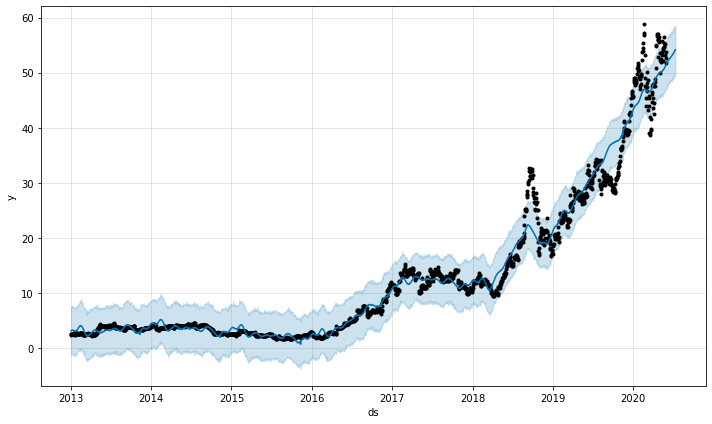

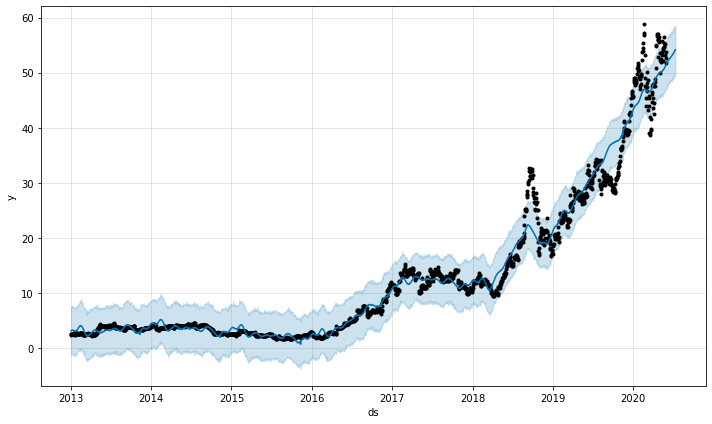

In [ ]:
# Prophet plots the observed values of our time series (the black dots), 
# the forecasted values (blue line) and the uncertainty intervals of our 
# forecasts (the blue shaded regions).
model_fd.plot(forecast_fd, uncertainty = True, xlabel = 'ds', ylabel = 'y')

# Comparison

The idea now is to take a look at the output dataframe of the filtered prophet model. We want to take a look at the forecast as we started at the end of May and forecasted until 7/10. Did it match the actuals?

We need to take a look at yhat since this is the forecast value. We should also take a look at yhat_lower and yhat_upper since these are the boundaries. 


In [ ]:
# This is the dataframe output of the 2nd model filtered on just the June and July time frame
time_period = forecast_fd[forecast_fd["ds"] > "2020-05-31"]

# Lets rename the column again since the original data frame has a Date column 
# and we can merge the dataframes to make it easier for comparing actual vs
# forecast and build visualizations for. 
time_period = time_period.rename(columns={'ds': 'Date'})

# Let's also trim the output to just include the yhat, yhat_lower and yhat_upper. 
time_period = time_period[["Date", "yhat", "yhat_lower", "yhat_upper"]]

time_period

,Date,yhat,yhat_lower,yhat_upper
1867,2020-06-01,51.701758,47.475831,56.014108
1868,2020-06-02,51.821485,47.250726,56.017051
1869,2020-06-03,51.856877,47.891229,56.311213
1870,2020-06-04,51.944957,47.609016,56.253922
1871,2020-06-05,51.985496,47.980746,56.546270
1872,2020-06-06,52.090955,47.832986,56.526585
1873,2020-06-07,52.160198,47.925619,56.539026
1874,2020-06-08,52.217870,47.990528,56.745517
1875,2020-06-09,52.321864,47.872914,56.482407
1876,2020-06-10,52.340703,48.082813,57.024140


Now lets trim up the original dataframe to only include the dates that are of interest. 

In [ ]:
# Filter out dates after 5/31 so that we can compare forecast vs actuals
# Remember we are using the amd_org since that was the cleaned dataframe from above. 
amd_close_filtered_date = amd_org[amd_org["Date"] > "2020-05-31"]
# We only need the Close column
amd_close_filtered_date = amd_close_filtered_date[["Date","Close"]]

amd_close_filtered_date

,Date,Close
1865,2020-06-01,53.630001
1866,2020-06-02,53.540001
1867,2020-06-03,52.730000
1868,2020-06-04,52.630001
1869,2020-06-05,53.099998
1870,2020-06-08,52.970001
1871,2020-06-09,56.389999
1872,2020-06-10,57.439999
1873,2020-06-11,52.830002
1874,2020-06-12,53.500000


Merge the dateframes based on the date!

Lets make sure our dataframes have the same length. The amount of columns is fine to be different but we do want an exact comparison on dates. 

In [ ]:
amd_close_filtered_date.shape

(29, 2)

In [ ]:
time_period.shape

(40, 4)

Here we can see they dont. This is because the forecast dataframe that fbprophet gave us has weekends. The original data set does not. 

Additionally, to ensure we are organized, our amd_close_filtered_date is our original stock prices pulled from the web. They are actuals so we want to compare them against the time_period data frame since it is our predicted stock prices. 

In [ ]:
# Merge the dataframes using outer on the Date column. 
# This was the reason we needed to rename the column for the time_period data frame from ds back to Date. 
merged = pd.merge(amd_close_filtered_date, time_period, on='Date', how='outer')
# Dropout rows with NA. The merge would have geenrated NaN values for the original data set since fbprophet forecasted for weekends. 
merged = merged.dropna()
# Rename the columns for clarity
merged = merged.rename(columns={'Close': 'Actual Stock Price',"yhat": "Predicted Stock Price", 
                                "yhat_lower" : "Predicted Lower Bound", "yhat_upper": "Predicted Upper Bound"})
merged

,Date,Actual Stock Price,Predicted Stock Price,Predicted Lower Bound,Predicted Upper Bound
0,2020-06-01,53.630001,51.701758,47.475831,56.014108
1,2020-06-02,53.540001,51.821485,47.250726,56.017051
2,2020-06-03,52.730000,51.856877,47.891229,56.311213
3,2020-06-04,52.630001,51.944957,47.609016,56.253922
4,2020-06-05,53.099998,51.985496,47.980746,56.546270
5,2020-06-08,52.970001,52.217870,47.990528,56.745517
6,2020-06-09,56.389999,52.321864,47.872914,56.482407
7,2020-06-10,57.439999,52.340703,48.082813,57.024140
8,2020-06-11,52.830002,52.411797,48.161582,56.697716
9,2020-06-12,53.500000,52.435307,48.216956,56.513673


# Visualizations

In [ ]:
# Set the Date as the index for plotting
merged.set_index('Date', inplace=True)

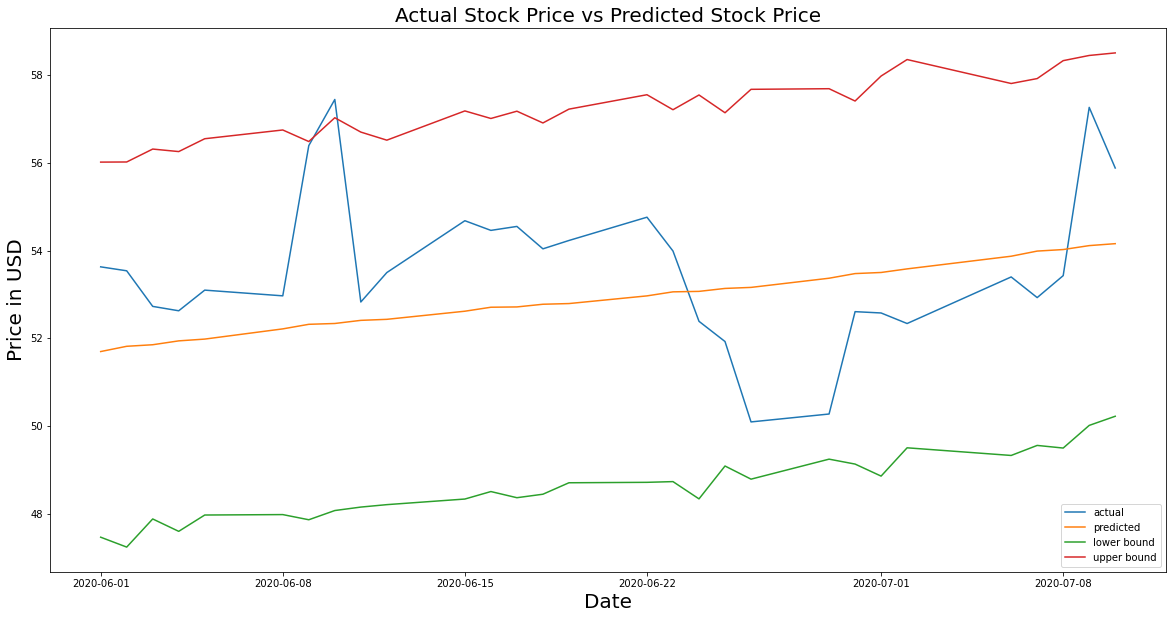

In [ ]:
# Make a new dataframe with just the columns we want to compare
new_merged = merged[["Actual Stock Price", "Predicted Stock Price"]]
plt.figure(figsize=(20,10))
plt.title("Actual Stock Price vs Predicted Stock Price", fontsize = 20)
plt.plot(merged['Actual Stock Price'])
plt.plot(merged['Predicted Stock Price'])
plt.plot(merged['Predicted Lower Bound'])
plt.plot(merged['Predicted Upper Bound'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price in USD', fontsize = 20)
plt.legend(["actual", "predicted", "lower bound", "upper bound"], loc ="lower right") 
plt.show()

In [ ]:
# Lets take a look at the mean prices between actual and predicted
mean_actual = merged["Actual Stock Price"].mean()
mean_predicted = merged["Predicted Stock Price"].mean()
print(mean_actual)
print(mean_predicted)

53.60689663064891
52.90171971574682


# Findings

In the grand scheme of things, when looking at the means of the two data points from 5/31 to 7/10, 42 days, there is not much difference even though our curves do not follow one another. 

Does the FB Prophet help us analyze stock data and now we can all beat the stock market?

In this case, there is a lot of variance still and we would want to both tigten our parameters as well as allow more data to be used to forecast before putting our money in and trusting this algorithm. With the variance though, we can say it did a reasonable job of predicting and utilizing other types of stock may result in better results.  

# Edit as of 7.28 Download Intel Stock to see the dip and rise in AMD

In [ ]:
# Grab the data for AMD
intel_org = web.DataReader('INTC', data_source='yahoo', start = "2020-07-01", end = '2020-07-28')
amd_new = web.DataReader('AMD', data_source='yahoo', start = "2020-07-01", end = '2020-07-28')

In [ ]:
# We only need the Close column

intel_org.reset_index(inplace = True, drop = False)
amd_new.reset_index(inplace = True, drop = False)
intel_org = intel_org[["Date","Close"]]
amd_new = amd_new[["Date","Close"]]

Merge the dateframes

In [ ]:
# Merge the dataframes using outer on the Date column. 
# This was the reason we needed to rename the column for the time_period data frame from ds back to Date. 
merged_new = pd.merge(intel_org, amd_new, on='Date', how='outer')
# Dropout rows with NA. The merge would have geenrated NaN values for the original data set since fbprophet forecasted for weekends. 
merged_new = merged_new.dropna()
# Rename the columns for clarity
merged_new = merged_new.rename(columns={"Close_x": "Intel", "Close_y": "AMD"})
merged_new

,Date,Intel,AMD
0,2020-07-01,58.810001,52.580002
1,2020-07-02,59.130001,52.340000
2,2020-07-06,59.540001,53.400002
3,2020-07-07,58.310001,52.930000
4,2020-07-08,58.610001,53.430000
5,2020-07-09,58.419998,57.259998
6,2020-07-10,59.529999,55.880001
7,2020-07-13,58.580002,53.590000
8,2020-07-14,58.980000,54.720001
9,2020-07-15,59.029999,55.340000


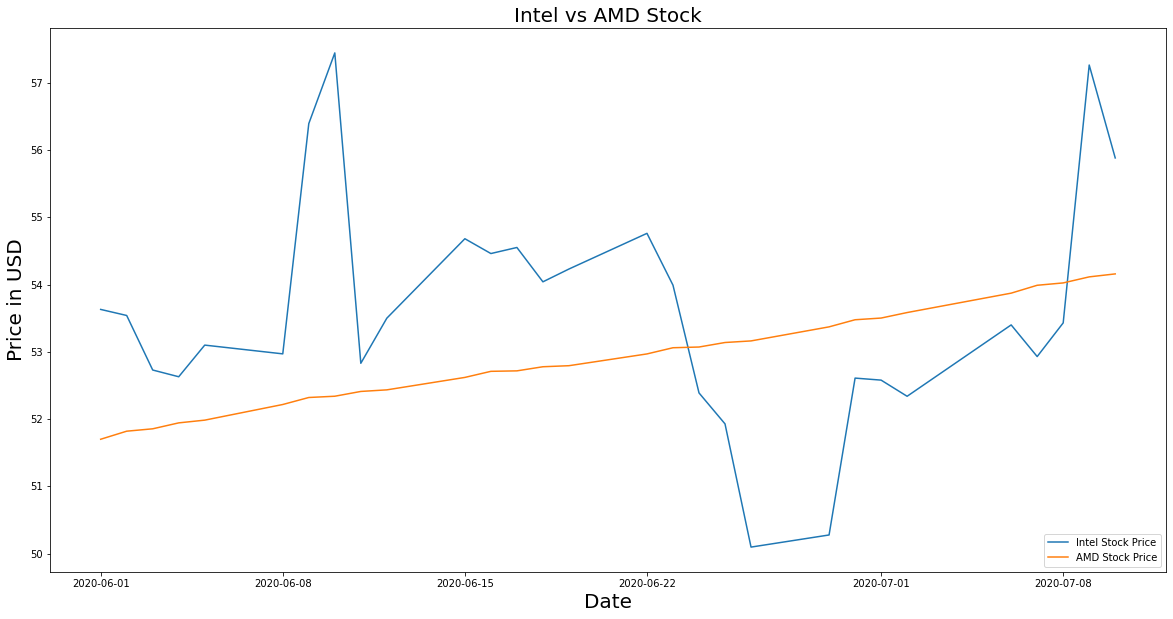

In [ ]:
# Make a new dataframe with just the columns we want to compare
new_merged = merged_new[["Intel", "AMD"]]
plt.figure(figsize=(20,10))
plt.title("Intel vs AMD Stock", fontsize = 20)
plt.plot(merged['Actual Stock Price'])
plt.plot(merged['Predicted Stock Price'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price in USD', fontsize = 20)
plt.legend(["Intel Stock Price", "AMD Stock Price"], loc ="lower right") 
plt.show()

In [ ]:
# name your csv
intel_org.to_csv('intel_org.csv') 
amd_new.to_csv('amd_new.csv') 

# download said csv
files.download('intel_org.csv') 
files.download('amd_new.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>